# Cleaning and plot tips

(I don't really have a useful name for this Notebook.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from typing import Literal

saf = pd.read_csv("data/Safiya_extract_3-1-2023.csv")
theo = pd.read_csv("data/Theo_Extract_2-21-2023.csv")


# Filtering features

Data sets should be reduced to the features you're actively using to save RAM as well as computational time. Filter your data as early as possible.

In [2]:
theo = theo.loc[
    :,
    [
        "adults",
        "age",
        "attend",
        "babies",
        "born",
        "childs",
        "citizen",
        "degree",
        "divorce",
        "ethclose",
        "ethnic",
        "famgen",
        "hapmar",
        "happy",
        "health",
        "income",
        "livecom1",
        "localgvt",
        "manners",
        "marital",
        "martype",
        "misswork",
        "natmeet",
        "overwork",
        "ownbiz",
        "parborn",
        "postlife",
        "race",
        "region",
        "rincome",
        "sex",
        "teens",
        "uscitzn",
        "wtssall",
        "widowed",
        "workhard",
        "wrkstat",
        "year",
    ],
]


# Proper types

Variables should be converted to the types that best represent their structure. Numbers should be integers (discrete values) or floats. Categorical variables should be `str` or [pandas.Categorical](https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html). Improper types will break algorithms. For example, a categorical feature that is encoded as an integer would be treated as a number.

Use [pandas.DataFrame.astype](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html) or the `Series` function for a single feature to convert types.

In [3]:
saf = saf.astype(
    {
        "year": "category",
        "age": "Int64",
        "educ": "Int64",
        "degree": "Int64",
        "letin1a": "Int64",
        "sex": "Int64",
        "race": "Int64",
        "partyid": "Int64",
        "othlang": "Int64",
        "age_c": "Int64",
        "decrease_imm": bool,
    }
)


I converted most of the `float`s to `Int64` since `pandas` incorrectly parsed them. They're discrete values not floating points. Integers are safer to convert to `categorical`s later as well due to the inaccuracy of floating points.

## Recoding variables

[pandas.Series.map](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) maps values in a `Series` to a new set of values. You can pass a `dict` that maps `old_value: new_value` or a function/lambda that returns the correct value. Here is an example using a function.

In [4]:
def recode_educ(educ):
    """Reduce GSS's `educ` variable to a few categories.

    Parameters
    ----------
    educ : int | pd.Int64Dtype
        Sentinel value GSS' `educ` variable.

    Returns
    -------
    str
        String representing the input's collapsed category.
    """
    if pd.isna(educ):
        return pd.NA
    elif educ == 0:
        # This can be collapsed into "Less than high school too"
        return "No schooling"
    elif educ < 13:
        return "Less than high school"
    elif educ < 17:
        return "College"
    elif educ < 19:
        return "Master's"
    elif educ >= 19 and educ < 97:
        return "Ph. D/Doctorate"
    else:
        return pd.NA


# Map the function over all of `educ`
saf["educ_cat"] = saf["educ"].map(recode_educ)

# A second example (mostly because I want to use this variable)
# This example leverages a new Python feature
def recode_partyid(party: int) -> Literal["Democrat", "Republican", "Other", pd.NA]:
    """Recode GSS's `partyid` variable by collapsing the redundant categories.

    https://gssdataexplorer.norc.org/variables/141/vshow

    Parameters
    ----------
    party : int | pd.Int64Dtype
        Sentinel value for GSS's `partyid` variable.

    Returns
    -------
    Literal["Democrat", "Republican", "Other", np.nan]
        String representing the input's collapsed category.
    """
    match party:
        case _ if pd.isna(party):
            return pd.NA
        case 0 | 1 | 2:
            return "Democrat"
        case 4 | 5 | 6:
            return "Republican"
        case 3 | 7:
            return "Other"
        case _:
            return pd.NA


saf["pol_party"] = saf["partyid"].map(recode_partyid)


Here are two examples using a `dict`. Functions or `lambda`s should be used when you need to map a range of values. Mapping with a `dict` is great for recoding data when you don't have a range as you'll see below.

In [5]:
# Map 1 to "Africa" and 17 to "Mexico"
theo["ethnic"] = theo["ethnic"].map({1: "Africa", 17: "Mexico"})

# Everything that wasn't 1 or 17 is now null.
# drop those nulls based on ethnicy's nullity
theo.dropna(how="any", subset=["ethnic"])

# And let's look at the results
theo["ethnic"].value_counts()


Africa    1072
Mexico     946
Name: ethnic, dtype: int64

A second example using [sex](https://gssdataexplorer.norc.org/variables/81/vshow).

In [6]:
saf["sex"] = saf["sex"].map({1: "Male", 2: "Female"}).astype("category")


## Frequency table

[pandas.Series.value_counts()](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) calculates a frequency table.

The table is a `Series` which you may customize as you wish.

In [7]:
# Calculate a frequency table and return that as a DataFrame
education_tab = saf.educ_cat.value_counts().to_frame()
# Calculate percents
education_tab = education_tab.assign(perc=education_tab / education_tab.sum() * 100)
# Cumulative sum
education_tab = education_tab.assign(perc_cumulative=education_tab.perc.cumsum())
# Sort table by percent
education_tab = education_tab.sort_values(by="perc", ascending=False)

education_tab


,educ_cat,perc,perc_cumulative
College,7029,44.722275,44.722275
Less than high school,6026,38.340650,83.062925
Master's,1643,10.453649,93.516574
Ph. D/Doctorate,988,6.286187,99.802761
No schooling,31,0.197239,100.000000


You can reorganize the table by reindexing using [reindex()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html). For example, let's say you'd like to organize the table so that it follows the order of the ordinal variable.

In [8]:
educ_order = [
    "No schooling",
    "Less than high school",
    "College",
    "Master's",
    "Ph. D/Doctorate",
]
education_tab = education_tab.reindex(educ_order)

education_tab


,educ_cat,perc,perc_cumulative
No schooling,31,0.197239,100.000000
Less than high school,6026,38.340650,83.062925
College,7029,44.722275,44.722275
Master's,1643,10.453649,93.516574
Ph. D/Doctorate,988,6.286187,99.802761


You can also use `pandas`' [Categorical](https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html) type which supports ordering.

In [9]:
saf["educ_cat"] = pd.Categorical(saf["educ_cat"], categories=educ_order, ordered=True)


# Plots

Plots are great to visually convey information about your data set. They're also useful for exploratory data analysis (E.D.A.).

## Bar

A quick horizontal bar chart using the recoded `educ`. Bar plots are perfect for drawing the counts of categorical variables. They shouldn't be used for continuous.

The plot is sorted exactly like the chart. I prefer ascending or descending to sorting by ordinals, but the plot below is fine too.

* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) - Returns a `Figure` and an `Axes` to plot on. This is cleaner than the `pyplot` interface.
* [Axes.barh](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.barh.html) - Draws a horizontal bar plot on the `Axes` obtained by calling `subplots()`.
* [Axes.set_title](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html) - Sets an `Axes` title. Click the link if you'd like to see other parameters you can use to customize the title.

**Note:** I skipped setting axis labels because the title explains the plot.

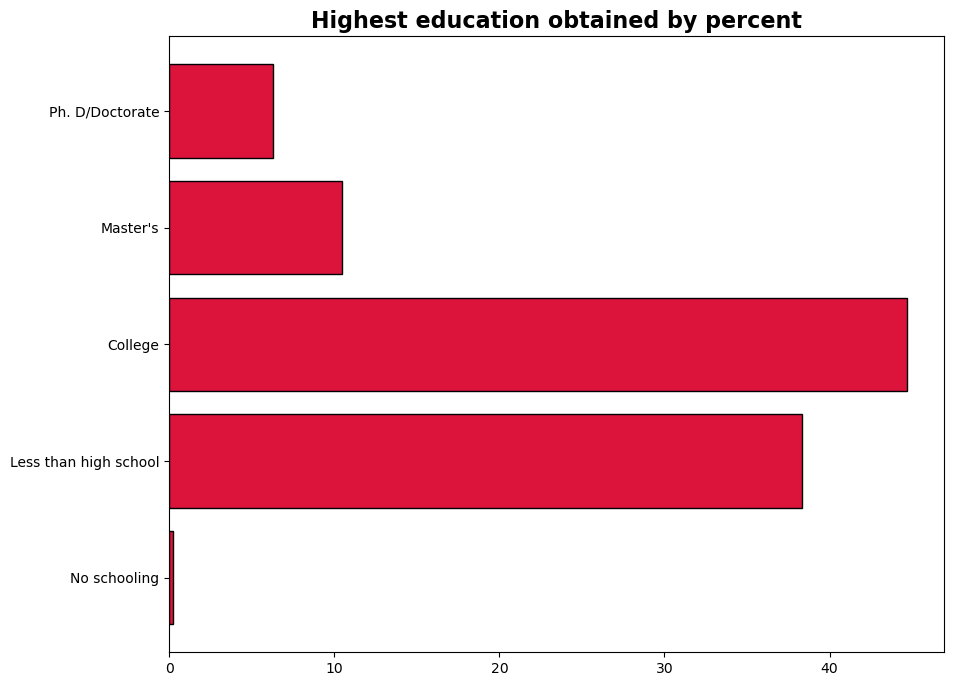

In [10]:
bar_fig, bar_ax = plt.subplots(figsize=(10, 8))
bar_ax.barh(education_tab.index, education_tab.perc, edgecolor="black", color="crimson")

# Axis titles and other aesthetics
_ = bar_ax.set_title(
    "Highest education obtained by percent", fontweight="bold", fontsize=16
)


## ~~Box~~ Violin plots

Box plots show the distribution of a variable along with other useful metrics like quartiles and outliers. However, box plots are flawed because they hide individual observations within the box. The amount of observations within each quartile isn't apparent which means that you don't see the full distribution.

Violin plots calculate a kernel density estimate of the data which shows a more complete picture of the underlying points. Violin plots may be paired with [strip plots](https://seaborn.pydata.org/generated/seaborn.stripplot.html) or other plots in order to convey more information within each violin. I didn't plot strip or swarm plots on top of the violins because there are too many data points, so it ends up looking kind of messy or crashes due to running out of memory.

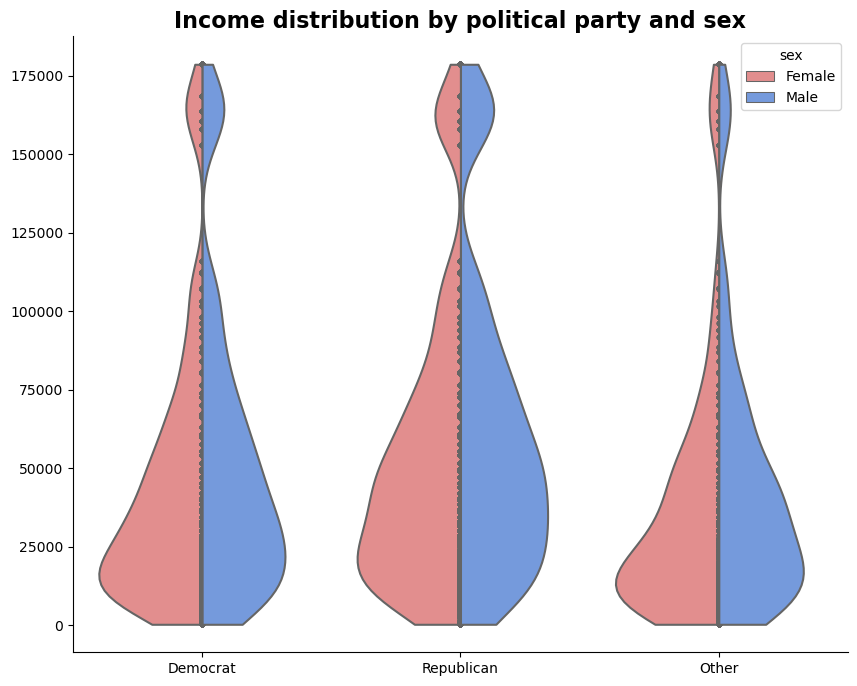

In [11]:
# Construct a Figure and Axes as usual
violin_fig, violin_ax = plt.subplots(figsize=(10, 8))

# Draw a violin plot on `violin_ax`
# Only the first three arguments are necessary
sns.violinplot(
    saf,
    x="pol_party",
    y="coninc",
    # Small multiples
    hue="sex",
    # Bandwidth estimation
    bw="scott",
    # Stop KDE data generation
    cut=0,
    # Draw observations instead of box plot
    inner="point",
    # Draw binary hue onto single violin
    split=True,
    palette={"Male": "cornflowerblue", "Female": "lightcoral"},
    ax=violin_ax,
)

# Aesthetics
_ = violin_ax.set_title(
    "Income distribution by political party and sex", fontweight="bold", fontsize=16
)
# Remove x and y axis labels because they add nothing to the plot
_ = violin_ax.set_xlabel(None)
_ = violin_ax.set_ylabel(None)
sns.despine(violin_fig, violin_ax)


# Density plots

Histograms and density plots draw the distribution of continuous features. **Histograms are essentially bar plots for continuous data.** Density plots are better than histograms because the data points aren't hidden by binning. It uses an estimation method like violins.

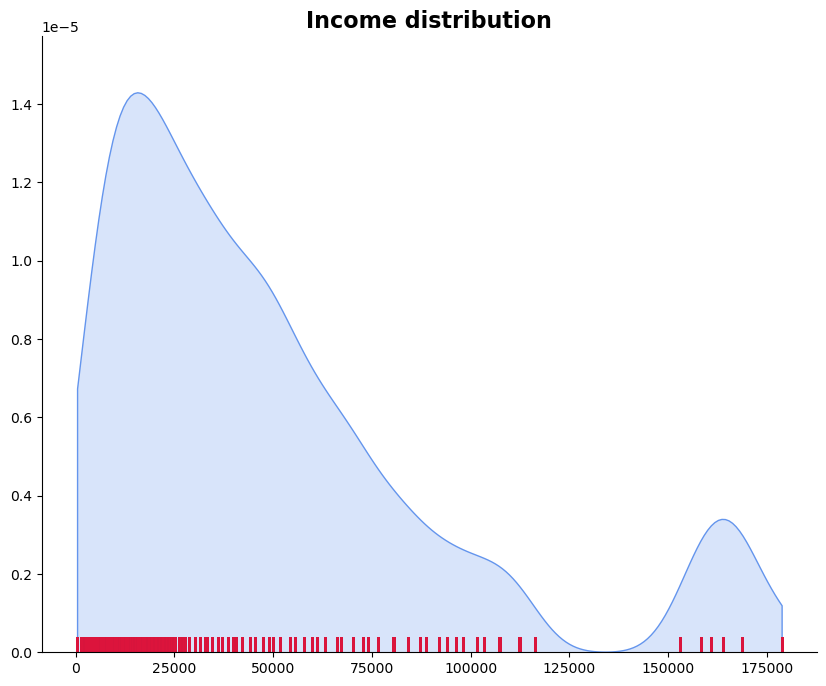

In [12]:
dens_fig, dens_ax = plt.subplots(figsize=(10, 8))

# Plot the KDE on dens_ax. Like with the other KDE, I set cut=0 to stop the data generation process.
sns.kdeplot(saf, x="coninc", color="cornflowerblue", cut=0, fill=True, ax=dens_ax)

# Plot a rug on top of the KDE to show where the observations are
sns.rugplot(saf, x="coninc", color="crimson", ax=dens_ax)

# And aesthetics
_ = dens_ax.set_title("Income distribution", fontweight="bold", fontsize=16)
# Remove unimportant labels
_ = dens_ax.set_xlabel(None)
_ = dens_ax.set_ylabel(None)
sns.despine(dens_fig, dens_ax)
